# import

In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import Orange

In [2]:
from config import *

sys.path.append(os.path.normpath('../../src'))
from experiment import AGG
from common import load_record, load_record_md3
from util import fix_plot

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sansmath}\n\\sansmath'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# results

In [4]:
SAVE_TO_FILE = False
SAVE_EXT = '.eps'

In [5]:
metric = 'mcc'

In [6]:
DETECTORS = {
    **OUR_DETECTORS,
    **USV_DETECTORS,
#     **SV_DETECTORS,
    **REFERENCES
}

In [7]:
dfs = []
for dataset in DATASETS:
    for detector in ALL_DETECTORS:
        agg = AGG(SAVE_DATA_DIR, dataset, detector)
        df = agg.select_results(**{k: v[0] for k, v in DETECTOR_PRMSS[detector].items()})
        df['dataset'] = dataset
        df['method'] = detector
        dfs.append(df)
df_base = pd.concat(dfs)

## score over time

In [8]:
def plt_score_base(ax, df, metric='mcc', skip=0.02, change_points=None):
    for idx, row in df.iterrows():
        _, _, _, _, _, score, drifts = load_record(row['record'])
        n_skip = int(score.index[-1] * skip)
        ax.plot(score[metric][n_skip:], c='k', lw=1)
        y_min = min(score[metric][n_skip:])
        y_max = max(score[metric][n_skip:])
        for drift in drifts:
            y = score[metric][drift]
            # to avoid y-axis range becomes to wide
            if drift < score[metric][n_skip:].index[0]:
                y = np.clip(y, y_min, y_max)
            ax.scatter(drift, y, c='r', marker='|', s=50, zorder=3)

    if change_points:
        [ax.axvline(cp, c='k', ls=':') for cp in change_points]
    ax.set_xlabel('instances')
    ax.set_ylabel('score')
    return ax

def plt_score_methods(df_base, methods, dataset, metric='mcc'):
    df = df_base.copy()
    df = df[df['dataset'] == dataset]
    change_points = DRIFT_POINTS.get(dataset, None)

    ncols = 4
    nrows = math.ceil(len(methods) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*1.5), sharex=True, sharey=True)
    axes = axes.flatten()
    for i, method in enumerate(methods):
        ax = axes[i]
        df_tmp = df[df['method'] == method]
        ax = plt_score_base(ax, df_tmp, metric=metric, change_points=change_points)
        ax.text(0.02, 0.05, method.replace('_', '-'), horizontalalignment='left', verticalalignment='bottom',
                transform=ax.transAxes)
        if (i // ncols) < (nrows - 1):
            ax.set_xlabel('')
        if (i % ncols) > 0:
            ax.set_ylabel('')
    while(i + 1 < nrows * ncols):
        i += 1
        axes[i].remove()
        
    return plt

In [9]:
def plt_score(df_base, methods, dataset, metric='mcc', skip=0.02):
    df = df_base.copy()
    df = df[df['dataset'] == dataset]
    change_points = DRIFT_POINTS.get(dataset, None)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 3), sharex=True)
    for method in methods:
        record = df[df['method'] == method]['record']
        if len(record) > 1:
            Exception('Condition is not specified.')
        _, _, _, _, _, score, drifts = load_record(record[0])
        label = method.replace('_', '-')
        n_skip = int(score.index[-1] * skip)
        score_plt = score[metric].iloc[n_skip:]
        ax.plot(score_plt, label=label)
        if method != 'update':
            score_plt = np.clip(score[metric][drifts], score_plt.min(), score_plt.max())
            ax.scatter(drifts, score_plt, marker='|', s=50, zorder=3)

    if change_points:
        [ax.axvline(cp, c='k', ls=':') for cp in change_points]
    ax.set_xlim(0, ax.get_xlim()[1] * 1.2)
    ax.set_xlabel('instances')
    ax.set_ylabel('score')
    ax.legend(loc='center right')

    return plt

Insects_A


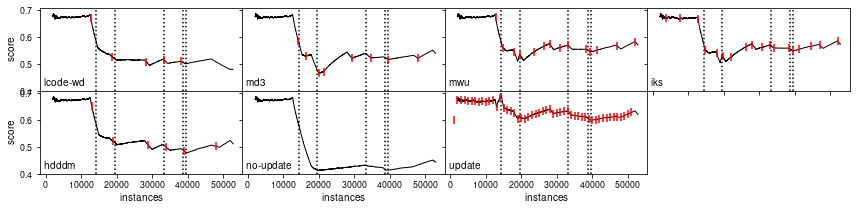

Insects_I


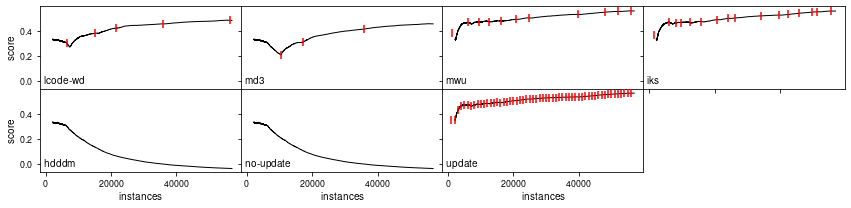

Insects_IG


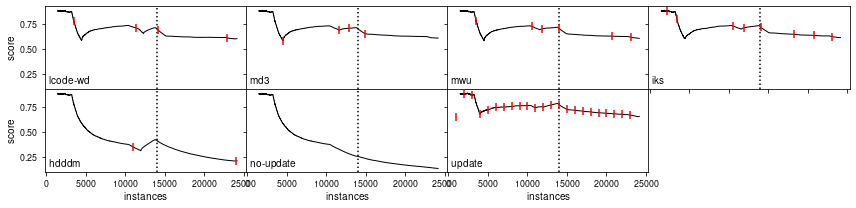

Insects_IR


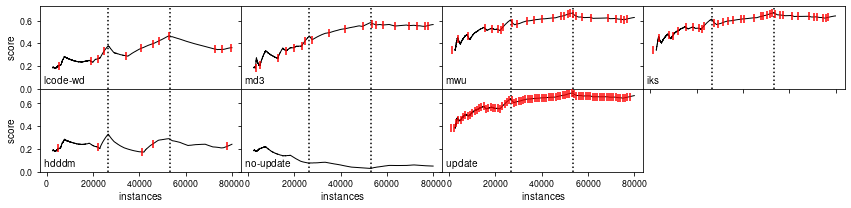

Insects_IAR


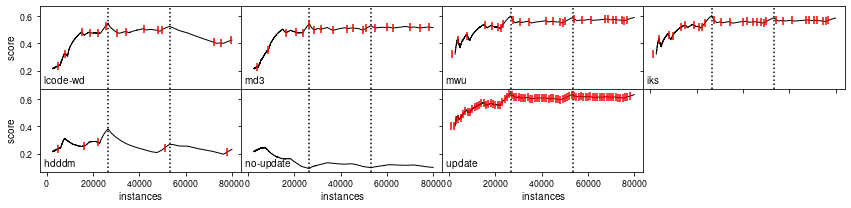

Insects_A_imb


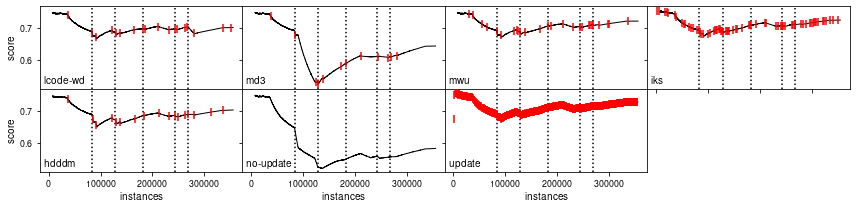

Insects_I_imb


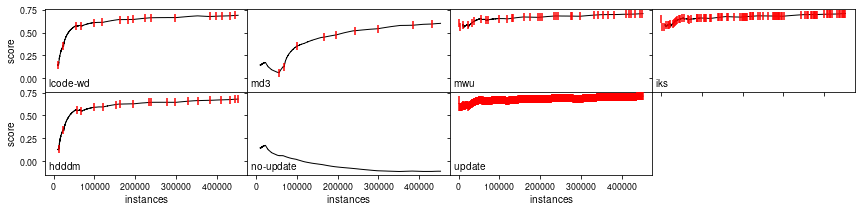

Insects_IG_imb


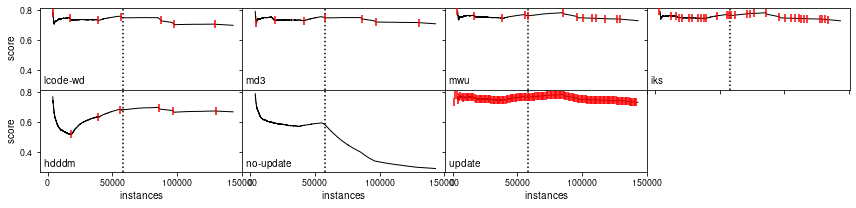

Insects_IR_imb


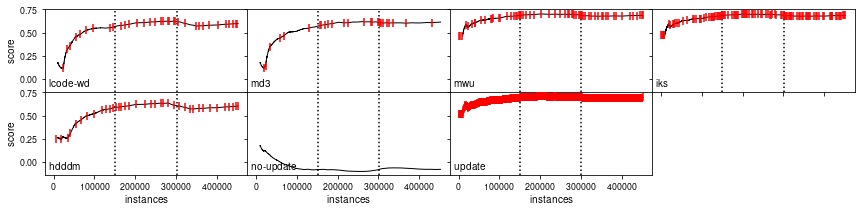

Insects_IAR_imb


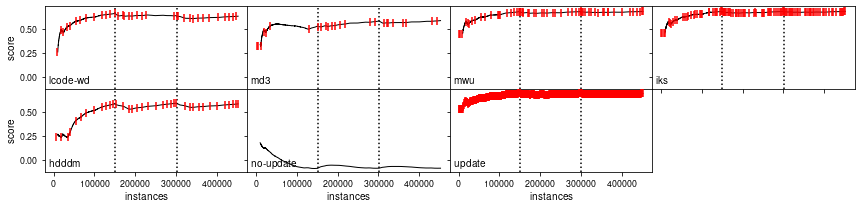

Insects_OOC


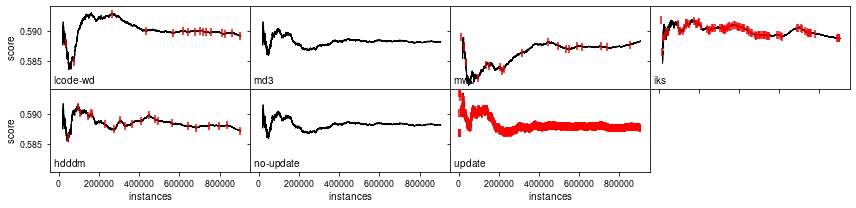

In [10]:
for dataset in DATASETS:
    print(dataset)
    save_path = os.path.join(OUTPUT_DIR, 'score_over_time_%s' % dataset)
    plt = plt_score_methods(df_base, DETECTORS, dataset, metric)
    fix_plot(plt, True, 0, 0, SAVE_TO_FILE, save_path, SAVE_EXT)

for dataset in DATASETS:
    print(dataset)
    save_path = os.path.join(OUTPUT_DIR, 'score_over_time_%s' % dataset)
    plt = plt_score(df_base, DETECTORS, dataset, metric)
    fix_plot(plt, True, 0, 0, SAVE_TO_FILE, None, SAVE_EXT)

## Performance summary

In [11]:
def calc_gain(df_base, dataset, metric):
    df = df_base.copy()
    df = df[df['dataset'] == dataset]

    base_score = df[df['method']=='no_update'][[metric]].values[0]
    data_len = pd.read_csv(df[df['method'] == 'no_update']['base_path'][0]).shape[0]
    train_size = df[df['method'] == 'no_update']['train_size'][0]

    tmp = []
    noa = []
    for idx, row in df.iterrows():
        if row['method'] == 'md3':
            alarms = load_record_md3(row['record'])
            effective_label_requests = [l for l in alarms if l < (data_len - train_size)]
            lr = len(effective_label_requests)*train_size/(data_len - train_size)
        elif (row['method'] in SV_DETECTORS) or (row['method'] == 'update'):
            alarms = row['drifts']
            lr = 1.0
        else:
            alarms = row['drifts']
            effective_label_requests = [l for l in alarms if l < (data_len - train_size)]
            lr = len(effective_label_requests)*train_size/(data_len - train_size)
        tmp.append(lr)
        noa.append(len(alarms))
            
    df = df[['dataset', 'method'] + [metric]]
    df['label ratio'] = tmp
    df['num of alarms'] = noa
    num = df[[metric]].values - base_score
    denom = df['label ratio'].values[:, None]
    gain = np.divide(num, denom, out=np.zeros_like(num), where=(denom>0))
    df_gain = pd.DataFrame(gain, columns=['gain / l.r.'])
    df_gain = pd.concat([df.reset_index(drop=True), df_gain], axis=1)
    df_gain = df_gain.set_index('method', drop=True)
    return df_gain

In [12]:
df_gain = []
for dataset in DATASETS:
    df_tmp = calc_gain(df_base, dataset, metric)
    df_tmp = df_tmp.drop('dataset', axis=1)
    df_tmp.columns = pd.MultiIndex.from_tuples([[dataset, c] for c in df_tmp.columns])
    df_gain.append(df_tmp)

df_gain = pd.concat(df_gain, axis=1)
with pd.option_context('display.precision', 3):
    df_gain.to_latex(os.path.join(OUTPUT_DIR, 'label_gain.txt'))

In [13]:
with pd.option_context('display.precision', 3):
    for c in df_gain[df_gain.columns.levels[0][0]].columns:
        print(c)
        display(df_gain.loc[ALL_DETECTORS].loc[:, (slice(None), c)].droplevel(level=1, axis=1))

mcc


,Insects_A,Insects_I,Insects_IG,Insects_IR,Insects_IAR,Insects_A_imb,Insects_I_imb,Insects_IG_imb,Insects_IR_imb,Insects_IAR_imb,Insects_OOC
method,,,,,,,,,,,
lcode_wd,0.481,0.483,0.606,0.361,0.425,0.701,0.688,0.696,0.599,0.634,0.589
md3,0.540,0.455,0.610,0.564,0.516,0.644,0.600,0.707,0.614,0.588,0.588
mwu,0.571,0.559,0.608,0.627,0.592,0.721,0.706,0.728,0.687,0.684,0.588
iks,0.574,0.558,0.616,0.640,0.588,0.724,0.707,0.727,0.687,0.684,0.589
hdddm,0.512,-0.038,0.211,0.241,0.231,0.703,0.678,0.669,0.602,0.584,0.587
ph,0.565,0.528,0.539,0.595,0.540,0.722,0.701,0.725,0.675,0.664,0.587
adwin,0.558,0.499,0.625,0.551,0.555,0.707,0.691,0.696,0.658,0.640,0.588
kswin,0.579,0.547,0.619,0.477,0.535,0.716,0.701,0.723,0.671,0.663,0.589
ddm,0.571,0.438,0.549,0.594,0.536,0.700,0.610,0.683,0.587,0.615,0.585


label ratio


,Insects_A,Insects_I,Insects_IG,Insects_IR,Insects_IAR,Insects_A_imb,Insects_I_imb,Insects_IG_imb,Insects_IR_imb,Insects_IAR_imb,Insects_OOC
method,,,,,,,,,,,
lcode_wd,0.096,0.071,0.173,0.139,0.165,0.051,0.038,0.049,0.075,0.078,0.018
md3,0.193,0.054,0.173,0.241,0.304,0.051,0.027,0.056,0.086,0.084,0.002
mwu,0.251,0.196,0.216,0.342,0.329,0.073,0.078,0.091,0.135,0.129,0.021
iks,0.328,0.286,0.346,0.430,0.380,0.195,0.188,0.225,0.228,0.228,0.101
hdddm,0.116,0.000,0.043,0.063,0.063,0.048,0.042,0.042,0.084,0.082,0.024
ph,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
adwin,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
kswin,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
ddm,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


num of alarms


,Insects_A,Insects_I,Insects_IG,Insects_IR,Insects_IAR,Insects_A_imb,Insects_I_imb,Insects_IG_imb,Insects_IR_imb,Insects_IAR_imb,Insects_OOC
method,,,,,,,,,,,
lcode_wd,5,5,4,12,14,18,17,7,34,35,16
md3,10,3,4,19,24,18,12,8,39,38,2
mwu,14,11,6,27,26,26,35,13,62,59,19
iks,18,16,8,34,30,69,85,32,104,104,91
hdddm,6,0,2,5,5,17,20,6,38,37,22
ph,8,8,4,20,19,18,18,10,38,38,21
adwin,8,5,4,17,20,15,14,7,39,38,0
kswin,15,18,7,20,26,34,66,19,78,79,313
ddm,14,6,3,23,25,20,11,13,28,40,1


gain / l.r.


,Insects_A,Insects_I,Insects_IG,Insects_IR,Insects_IAR,Insects_A_imb,Insects_I_imb,Insects_IG_imb,Insects_IR_imb,Insects_IAR_imb,Insects_OOC
method,,,,,,,,,,,
lcode_wd,0.375,7.285,2.739,2.242,1.993,2.328,21.102,8.265,9.011,9.299,5.604e-02
md3,0.493,9.201,2.762,2.145,1.379,1.197,26.589,7.416,8.028,8.019,0.000e+00
mwu,0.502,3.037,2.202,1.692,1.504,1.884,10.483,4.791,5.671,5.998,6.702e-03
iks,0.391,2.084,1.399,1.375,1.292,0.726,4.323,1.942,3.358,3.381,5.980e-03
hdddm,0.580,0.000,1.814,3.036,2.111,2.497,18.661,8.987,8.097,8.189,-3.766e-02
ph,0.120,0.565,0.406,0.547,0.442,0.139,0.809,0.435,0.755,0.752,-1.015e-03
adwin,0.113,0.537,0.493,0.503,0.457,0.124,0.798,0.406,0.738,0.728,0.000e+00
kswin,0.133,0.585,0.487,0.429,0.437,0.133,0.809,0.433,0.752,0.751,5.272e-04
ddm,0.126,0.476,0.417,0.546,0.439,0.118,0.718,0.393,0.667,0.702,-3.076e-03


In [14]:
n_level = len(df_gain.columns.levels[1])

## Bar plot

In [15]:
ncols = 4
nrows = (len(DATASETS) + ncols) // ncols

In [16]:
def make_legend(df, ax):
    types = [DETECTOR_TYPES[method] for method in df.index]
    types = sorted(set(types), key=types.index)
    
    ax.get_shared_x_axes().remove(ax)
    ax.get_shared_y_axes().remove(ax)
    ax.xaxis.major = mpl.axis.Ticker()
    ax.yaxis.major = mpl.axis.Ticker()
    ax.xaxis.set_major_locator(mpl.ticker.AutoLocator())
    ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())

    bars = [ax.bar(i, 0, color=COLORS[t]) for i, t in enumerate(types)]
    ax.legend(bars, types, loc='center', bbox_to_anchor=(0.5, 0.5), frameon=False, handletextpad=0.2)
    ax.axis('off')

In [17]:
def plot_result_bar(m, nrows, ncols, ylabel, ylim=(None, None), sharey=True):
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.5), sharex=True, sharey=sharey)
    axes = axes.flatten()
    for i, col in enumerate(m.columns):
        ax = axes[i]
        if ylim[0] is not None:
            v = m[col] - ylim[0]
            v.plot.bar(ax=ax, bottom=ylim[0], color=[COLORS[DETECTOR_TYPES[method]] for method in m.index], width=0.8)
        else:
            m[col].plot.bar(ax=ax, color=[COLORS[DETECTOR_TYPES[method]] for method in m.index], width=0.8)
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=90)
        ax.tick_params(axis='y', direction='in')
        ax.text(0.98, 0.98, col.replace('_', '-'), horizontalalignment='right', verticalalignment='top',
                transform=ax.transAxes)

        if (i // ncols) < (nrows - 1):
            ax.xaxis.set_visible(False)
        else:
            ax.set_xticklabels(m.index.str.replace('_', '-'))
            
        if (i % ncols) == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel('')

    ax.set_ylim(ylim)
    i = i + 1  # keep for legend
    make_legend(m, ax=axes[i])
    while(i + 1 < nrows * ncols):
        i += 1
        axes[i].remove()
        
    return plt

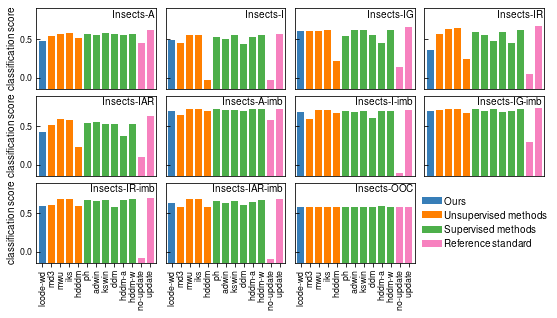

In [18]:
basename = '_'.join(('score', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 0::n_level].droplevel(level=1, axis=1)
plt = plot_result_bar(df, nrows, ncols, ylabel='classification score', ylim=(-0.15, 0.9))
fix_plot(plt, True, 0.08, 0.08, SAVE_TO_FILE, save_path, SAVE_EXT)

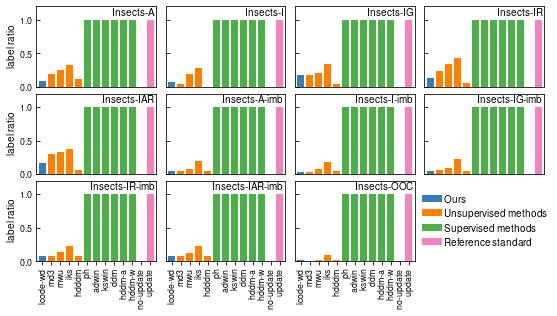

In [19]:
basename = '_'.join(('label_ratio', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 1::n_level].droplevel(level=1, axis=1)
plt = plot_result_bar(df, nrows, ncols, ylabel='label ratio', ylim=(0, 1.2))
fix_plot(plt, True, 0.08, 0.08, SAVE_TO_FILE, save_path, SAVE_EXT)

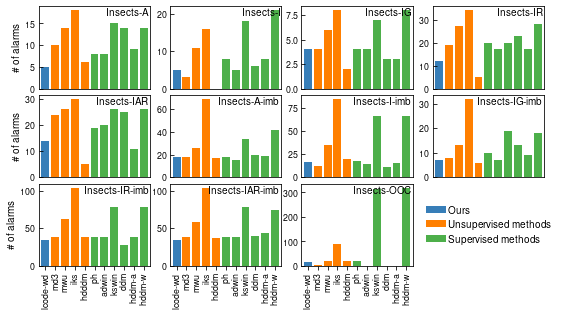

In [20]:
basename = '_'.join(('num_of_alarms', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:-2, 2::n_level].droplevel(level=1, axis=1)
plt = plot_result_bar(df, nrows, ncols, ylabel='\# of alarms', sharey=False)
fix_plot(plt, True, 0.18, 0.08, SAVE_TO_FILE, save_path, SAVE_EXT)

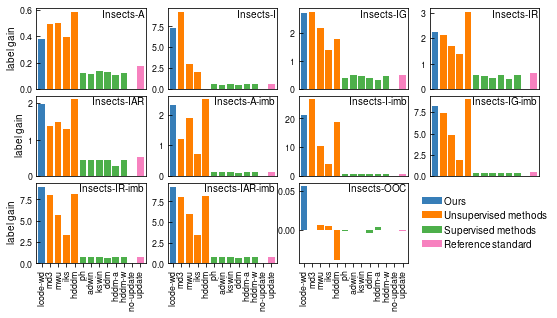

In [21]:
basename = '_'.join(('label_gain', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 3::n_level].droplevel(level=1, axis=1)
plt = plot_result_bar(df, nrows, ncols, ylabel='label gain', sharey=False)
fix_plot(plt, True, 0.2, 0.08, SAVE_TO_FILE, save_path, SAVE_EXT)

## CD plot

In [22]:
def plt_CD(df_rank, width=10, save_path=None):
    names = df_rank.columns.str.replace("_", "-")
    avranks = df_rank.mean()
    cd = Orange.evaluation.compute_CD(avranks, len(df_rank))

    if SAVE_TO_FILE and save_path:
        filename = save_path + SAVE_EXT
    else:
        filename = None
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=width, filename=filename)

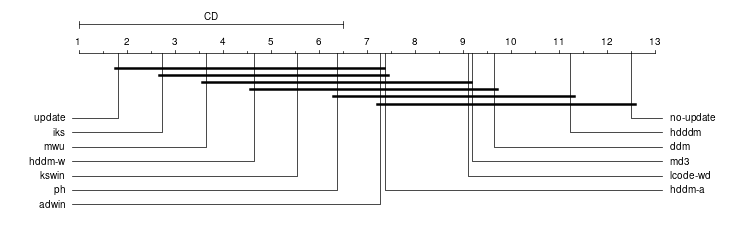

In [23]:
basename = '_'.join(('score', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 0::n_level].droplevel(level=1, axis=1)
df_rank = df.rank(method='average', ascending=False).T[ALL_DETECTORS]
plt_CD(df_rank, save_path=save_path + '_CD')

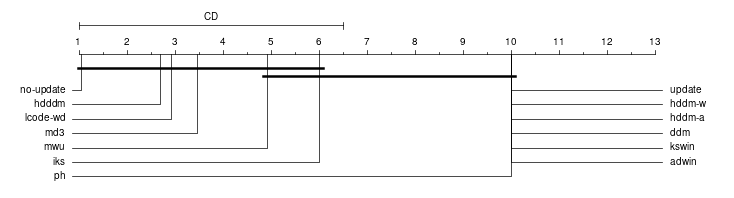

In [24]:
basename = '_'.join(('label_ratio', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 1::n_level].droplevel(level=1, axis=1)
df_rank = df.rank(method='average', ascending=True).T[ALL_DETECTORS]
plt_CD(df_rank, save_path=save_path + '_CD')

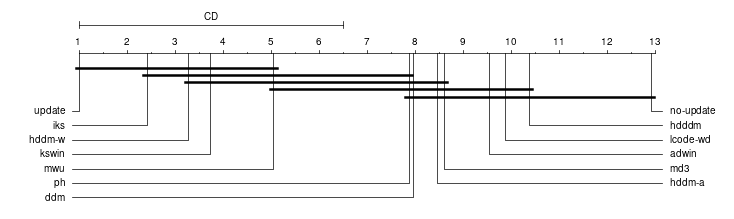

In [25]:
basename = '_'.join(('num_of_alarms', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 2::n_level].droplevel(level=1, axis=1)
df_rank = df.rank(method='average', ascending=False).T[ALL_DETECTORS]
plt_CD(df_rank, save_path=save_path + '_CD')

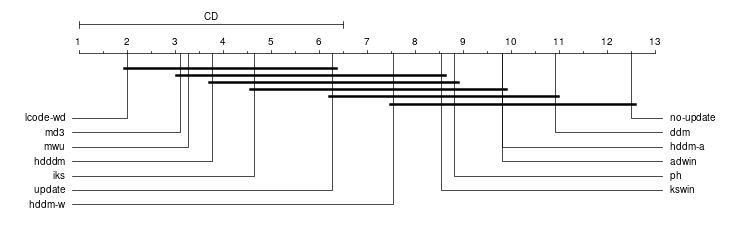

In [26]:
basename = '_'.join(('label_gain', 'Insects'))
save_path = os.path.join(OUTPUT_DIR, basename)
df = df_gain.loc[ALL_DETECTORS].iloc[:, 3::n_level].droplevel(level=1, axis=1)
df_rank = df.rank(method='average', ascending=False).T[ALL_DETECTORS]
plt_CD(df_rank, save_path=save_path + '_CD')